# Map slicing, bounds, addressing and location view research

In [1]:
import os
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.transform import from_bounds
from shapely.geometry import box
import matplotlib.pyplot as plt

# Initial testing with numpy slicing

In [2]:
arr = np.arange(64).reshape((8,8))
print(arr)
height, width = arr.shape
arr[:height//2,:width//2]
arr[:height//2,width//2:]
arr[height//2:,:width//2]
arr[height//2:,width//2:]

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


array([[36, 37, 38, 39],
       [44, 45, 46, 47],
       [52, 53, 54, 55],
       [60, 61, 62, 63]])

# Box class to check if coord is in bounds

In [3]:
class Box:
    def __init__(self, bounds=None, left:int=0, bottom:int=0, right:int=0, top:int=0):
        if bounds is not None: self.left,self.bottom,self.right,self.top = bounds
        else: self.left,self.bottom,self.right,self.top = left,bottom,right,top
        self.width, self.height = self.right -self.left, self.top -self.bottom
    def __str__(self):
        return "left:{} bottom:{} right:{} top:{} width:{} height:{}".format(
            self.left, self.bottom, self.right, self.top, self.width, self.height)
    def in_bounds(self, x:int, y:int) -> bool:
        return self.left < x < self.right and self.bottom < y < self.top

# Subdivide and log bounds to dict

In [4]:
def subdivide(name:str, tif:rio.io.DatasetReader, sub:int=2) -> None:
    if sub is 0: return
    
    arr = np.array(tif.read(1))
    meta = tif.meta
    bounds = tif.bounds
    
    meta["width"]  /= 2
    meta["height"] /= 2
    
    sub_bound = {
        0:(0,1,-1,0),
        1:(1,1,0,0),
        2:(0,0,-1,-1),
        3:(1,0,0,-1)}
    
    sub_slice = {
        0:{"sx":slice(None,int(meta["height"])),
           "sy":slice(None,int(meta["width"]))},
        1:{"sx":slice(None,int(meta["height"])),
           "sy":slice(int(meta["width"]),None)},
        2:{"sx":slice(int(meta["height"]),None),
           "sy":slice(None,int(meta["width"]))},
        3:{"sx":slice(int(meta["height"]),None),
           "sy":slice(int(meta["width"]),None)}}
    
    for idx in range(4):        
        meta["transform"] = from_bounds(
            bounds.left + meta["width"] * sub_bound[idx][0],
            bounds.bottom + meta["height"] * sub_bound[idx][1],
            bounds.right + meta["width"] * sub_bound[idx][2],
            bounds.top + meta["height"] * sub_bound[idx][3],
            meta["width"], meta["height"]
        )
        with rio.open(name +f"_{idx}.tif", "w+", **meta) as subdiv:
            subdiv.write(arr[sub_slice[idx]["sx"],sub_slice[idx]["sy"]], indexes=1)
            subdivide(name +f"_{idx}", subdiv, sub-1)
            if sub > 1: os.remove(name +f"_{idx}.tif")
            else: sub_lookup[name[2:] +f"_{idx}"] = Box(subdiv.bounds)

sub_lookup = {}

k15_path = "/home/becode/Projects/3D_House/LIDAR/k15/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15.tif"
k15_tif = rio.open(k15_path)
subdivide("./k15", k15_tif, 5)
print("Done!")

Done!


# Print the sub_lookup dictionary boundaries

In [5]:
k15_bounds = k15_tif.bounds
print(f"big bounds: {k15_bounds}")

for idx, (file, box) in enumerate(sub_lookup.items()):
    if idx > 11: break
    print(f"{file}: {box}")
print("\tetc...")
print("k15_3_3_3_3_3: " + str(sub_lookup["k15_3_3_3_3_3"]))

big bounds: BoundingBox(left=130000.0, bottom=198000.0, right=162000.0, top=218000.0)
k15_0_0_0_0_0: left:130000.0 bottom:217375.0 right:131000.0 top:218000.0 width:1000.0 height:625.0
k15_0_0_0_0_1: left:131000.0 bottom:217375.0 right:132000.0 top:218000.0 width:1000.0 height:625.0
k15_0_0_0_0_2: left:130000.0 bottom:216750.0 right:131000.0 top:217375.0 width:1000.0 height:625.0
k15_0_0_0_0_3: left:131000.0 bottom:216750.0 right:132000.0 top:217375.0 width:1000.0 height:625.0
k15_0_0_0_1_0: left:132000.0 bottom:217375.0 right:133000.0 top:218000.0 width:1000.0 height:625.0
k15_0_0_0_1_1: left:133000.0 bottom:217375.0 right:134000.0 top:218000.0 width:1000.0 height:625.0
k15_0_0_0_1_2: left:132000.0 bottom:216750.0 right:133000.0 top:217375.0 width:1000.0 height:625.0
k15_0_0_0_1_3: left:133000.0 bottom:216750.0 right:134000.0 top:217375.0 width:1000.0 height:625.0
k15_0_0_0_2_0: left:130000.0 bottom:216125.0 right:131000.0 top:216750.0 width:1000.0 height:625.0
k15_0_0_0_2_1: left:131

# Bounds dictionary pandas writer

In [6]:
import pandas as pd
with open("./bounds.csv", "w") as csv:
    csv.write("|".join(("Parent","File","Name",
                       "Left","Bottom","Right","Top",
                       "Width","Height")) +"\n")
    for file, box in sub_lookup.items():
        csv.write("|".join((
            "K15",f"./{file}.tif",file,
            str(box.left),str(box.bottom),str(box.right),str(box.top),
            str(box.width),str(box.height))) +"\n")
bounds_df = pd.read_csv("./bounds.csv", sep="|")
bounds_df

,Parent,File,Name,Left,Bottom,Right,Top,Width,Height
0,K15,./k15_0_0_0_0_0.tif,k15_0_0_0_0_0,130000.0,217375.0,131000.0,218000.0,1000.0,625.0
1,K15,./k15_0_0_0_0_1.tif,k15_0_0_0_0_1,131000.0,217375.0,132000.0,218000.0,1000.0,625.0
2,K15,./k15_0_0_0_0_2.tif,k15_0_0_0_0_2,130000.0,216750.0,131000.0,217375.0,1000.0,625.0
3,K15,./k15_0_0_0_0_3.tif,k15_0_0_0_0_3,131000.0,216750.0,132000.0,217375.0,1000.0,625.0
4,K15,./k15_0_0_0_1_0.tif,k15_0_0_0_1_0,132000.0,217375.0,133000.0,218000.0,1000.0,625.0
...,...,...,...,...,...,...,...,...,...
1019,K15,./k15_3_3_3_2_3.tif,k15_3_3_3_2_3,159000.0,198000.0,160000.0,198625.0,1000.0,625.0
1020,K15,./k15_3_3_3_3_0.tif,k15_3_3_3_3_0,160000.0,198625.0,161000.0,199250.0,1000.0,625.0
1021,K15,./k15_3_3_3_3_1.tif,k15_3_3_3_3_1,161000.0,198625.0,162000.0,199250.0,1000.0,625.0
1022,K15,./k15_3_3_3_3_2.tif,k15_3_3_3_3_2,160000.0,198000.0,161000.0,198625.0,1000.0,625.0


# Find .tif containing given x & y

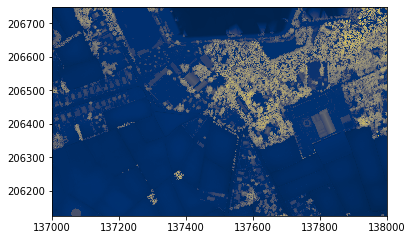

In [7]:
from random import randint
x = randint(k15_bounds.left,k15_bounds.right)
y = randint(k15_bounds.bottom,k15_bounds.top)
for file, box in sub_lookup.items():
    if box.in_bounds(x, y):
        show(rio.open(f"./{file}.tif"), cmap="cividis")

# Initial testing address info request

In [8]:
import requests
import json
address = "Molenstraat 52 Sint-Kat"
req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={address}&c=1")
req.json()
for key, value in req.json()["LocationResult"][0].items():
    print(f"{key} : {value}")

Municipality : Sint-Katelijne-Waver
Zipcode : 2861
Thoroughfarename : Molenstraat
Housenumber : 52
ID : 1524026
FormattedAddress : Molenstraat 52, 2861 Sint-Katelijne-Waver
Location : {'Lat_WGS84': 51.06336314263222, 'Lon_WGS84': 4.587194565939624, 'X_Lambert72': 165312.83, 'Y_Lambert72': 194824.78}
LocationType : crab_huisnummer_afgeleidVanGebouw
BoundingBox : {'LowerLeft': {'Lat_WGS84': 51.06336314263222, 'Lon_WGS84': 4.587194565939624, 'X_Lambert72': 165312.83, 'Y_Lambert72': 194824.78}, 'UpperRight': {'Lat_WGS84': 51.06336314263222, 'Lon_WGS84': 4.587194565939624, 'X_Lambert72': 165312.83, 'Y_Lambert72': 194824.78}}


# Show map containing address

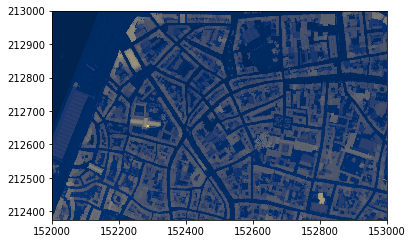

In [9]:
def get_lambert(address:str) -> (int,int): 
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={address}&c=1")
    return (req.json()["LocationResult"][0]["Location"]["X_Lambert72"],
            req.json()["LocationResult"][0]["Location"]["Y_Lambert72"])

x, y = get_lambert("Sint-Pietersvliet 7, 2000 Antwerpen")
for file, box in sub_lookup.items():
    if box.in_bounds(x, y):
        show(rio.open(f"./{file}.tif"), cmap="cividis")

# Crop image around building

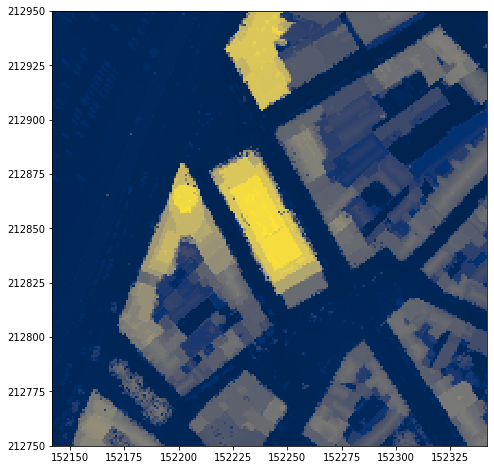

In [10]:
def get_containing_tif(x:int, y:int) -> rio.io.DatasetReader:
    for file, box in sub_lookup.items():
        if box.in_bounds(x, y):
            return rio.open(f"./{file}.tif")

def crop_location(tif, width:int=200, height:int=200) -> rio.io.DatasetReader:
    arr = np.array(tif.read(1))
    meta, bounds = tif.meta, tif.bounds
    posx, posy = int(x -bounds.left), int(abs(y -bounds.top))
    slicex = slice(posx -width//2, posx +width//2)
    slicey = slice(posy -height//2, posy +height//2)
    meta["width"], meta["height"] = width, height
    meta["transform"] = from_bounds(
        bounds.left + slicex.start,
        bounds.top - slicey.stop,
        bounds.left + slicex.stop,
        bounds.top - slicey.start,
        width, height)
    with rio.open("./crop.tif", "w", **meta) as crop:
        crop.write(arr[slicey,slicex], indexes=1)
    return rio.open("./crop.tif")

x, y = get_lambert("Sint-Pietersvliet 7, 2000 Antwerpen")
tif = get_containing_tif(x, y)
plt.figure(figsize=(8,8))
show(crop_location(tif,200,200), cmap="cividis")